### OBJ Mesh Voxel Visualization Tool
*A utility to convert voxel data stored in a 3D NumPy array into a collection of OBJ mesh cubes for visualizing, sharing, and rendering.*
- Configured to accept voxel data stored in a numpy array (.npy).
- *Does not* create a single body mesh for 3D printing purposes
- Made to create obj files that can be easily shared or included in visuals/renders.  

In [1]:
# Dependencies
from obj_voxel_visualizer import * 

# For data collection, inline display, and plotting metrics
import os
import time
import glob
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import trimesh
from string import Template

---
#### Convert Numpy Voxel Array to OBJ Voxel Mesh Visual

In [2]:
# Export voxel array to OBJ mesh using function that includes loading and voxel count limit warning.

npy_filename = "example_visualized_voxels/lobe_gear/Lobe_Gear.npy"
obj_filename = "lobe_gear_example.obj"

# Function checks voxel count limit to confirm creating large files.
# Surface View is on by default
obj_voxel_visualizer( npy_filename, obj_filename )

Number of Mesh Voxels Created: 19149
Surface View Enabled: True
Exported OBJ Filename: lobe_gear_example.obj


In [3]:
# Export OBJ mesh from pre-loaded NumPy array data

example_voxel_array = np.load("example_visualized_voxels/lobe_gear/Lobe_Gear.npy")

voxel_array2voxel_mesh_obj( obj_filename, example_voxel_array )

In [ ]:
# Load exported OBJ mesh to view voxel model
mesh = trimesh.load(obj_filename)
mesh.show()

---
#### Improvements Gained from Original Voxel Array to Voxel Mesh Data Function
The original conversion function suffered from a slow runtime. Refactoring the function to use NumPy's optimized functions resulted in a significant time savings especially with a large voxel count. The improvements are mainly located in the surface voxel filtering function which uses stride tricks in place of python loops.

In [5]:
# Load in NumPy array with large number of voxels

voxel_benchmark_array = np.load("npy_voxel_arrays_nittany_lion/nittany-lion-0.5-voxel-array.npy")
print(np.count_nonzero(voxel_benchmark_array)) # Note: this counts all voxels in array

548078


In [6]:
# Measure runtime of old voxel array to vertices and faces function
start_old = time.time()
old_verts, old_faces = old_voxel_array2mesh( voxel_benchmark_array, surface_view = True )
end_old = time.time()

print("Total voxels in mesh model: %d"% (old_faces.shape[0]/12))
print("Elapsed function runtime = %s seconds"% round((end_old - start_old), 2))

Total voxels in mesh model: 83142
Elapsed function runtime = 5.7 seconds


In [7]:
# Measure runtime of old voxel array to vertices and faces function
start_new = time.time()
new_verts, new_faces = voxel_array2mesh( voxel_benchmark_array, surface_view = True )
end_new = time.time()

print("Total voxels in mesh model: %d"% (new_faces.shape[0]/12))
print("Elapsed function runtime = %s seconds"% round((end_new - start_new), 2))

Total voxels in mesh model: 83142
Elapsed function runtime = 0.24 seconds


In [8]:
# Calculated Efficiency Gained
print("The new Surface Voxel function is x%s faster"% 
      round((end_old - start_old)/(end_new - start_new), 2))

The new Surface Voxel function is x23.56 faster


---
#### Measuring Impact of Number of Voxels on File Size
A clear drawback of the voxel mesh files create is the size of the file. As the voxel resolution increases, the size of both the OBJ and NPY file can increase rapidly. Voxel count warnings are included to prevent creating GB size files, but it is important to illustrate the relationship between voxel count, voxel resolution, and file size.

In [9]:
# Collect files from respective folders
voxel_data_array_folder = "./npy_voxel_arrays_nittany_lion/*.npy"
voxel_mesh_model_folder = "./obj_voxel_meshes_nittany_lion/*.obj"

data_arrays = np.asarray(sorted(glob.glob(voxel_data_array_folder)))
mesh_models = np.asarray(sorted(glob.glob(voxel_mesh_model_folder)))

In [10]:
# Initialize a dataframe to store the voxel data

mesh_model_files = np.char.strip(mesh_models, './obj_voxel_meshes_nittany_lion/nittany-lion-')
edge_lengths = np.char.strip(mesh_model_files, '-voxel-mesh.obj').astype('float')

voxel_file_df = pd.DataFrame({
  "NPY File": data_arrays,
  "OBJ File": mesh_models,
  "Voxel Edge Length": edge_lengths,
}).sort_values( by=['Voxel Edge Length'], ignore_index=True )
# voxel_file_df

In [11]:
# Collect file size of NPY array and OBJ mesh files
npy_size = []
obj_size = []
npy_raw_size = []
obj_raw_size = []

for idx, row in voxel_file_df.iterrows():
  npy_size_bytes = os.path.getsize(row['NPY File'])
  obj_size_bytes = os.path.getsize(row['OBJ File'])
  npy_raw_size.append( npy_size_bytes )
  obj_raw_size.append( obj_size_bytes )
  npy_size.append( str(convert_size(npy_size_bytes)) )
  obj_size.append( str(convert_size(obj_size_bytes)) )

size_df = pd.DataFrame({
  'NPY Raw Size': npy_raw_size,
  'OBJ Raw Size': obj_raw_size,
  'NPY File Size': npy_size,
  'OBJ File Surf-Vox Size': obj_size
})
# size_df

In [12]:
# Count total number of voxels and number of surface voxels in each file (long runtime)
vox_count = []
surfvox_count = []
surfvox_percent = []

for idx, file in voxel_file_df['NPY File'].items():
  voxarr = np.load(file)
  num_vox = np.count_nonzero(voxarr)
  num_surfvox = np.count_nonzero(get_surface_voxels(voxarr))
  vox_count.append( num_vox )
  surfvox_count.append( num_surfvox )
  surfvox_percent.append(round(( num_surfvox/num_vox )*100, 2 ))

count_df = pd.DataFrame({ 
  'Voxel Count': vox_count,
  'Surface Voxel Count': surfvox_count,
  'Surface Voxel Percentage': surfvox_percent
})
# count_df

In [13]:
# Voxel Scale Ratio Calculation (Percentage of the bounding box unit magnitude)
bounding_unit_magnitude = []
vox_scale_ratio = []

for idx, row in voxel_file_df.iterrows():
  voxel_arr = np.load(row['NPY File'])
  unit_magnitude = np.linalg.norm(voxel_arr.shape)
  inverse_mag_percent = (1/unit_magnitude) * 100
  bounding_unit_magnitude.append(unit_magnitude)
  vox_scale_ratio.append( round(inverse_mag_percent, 4) )

scale_df = pd.DataFrame({
  'Bounding Volume Unit Magnitude': bounding_unit_magnitude,
  'Voxel Scale Percentage': vox_scale_ratio
})
# scale_df

In [14]:
# Assemble Voxel Info DataFrame
voxel_df = pd.concat( [ size_df, scale_df, count_df ], axis=1 )
voxel_df

,NPY Raw Size,OBJ Raw Size,NPY File Size,OBJ File Surf-Vox Size,Bounding Volume Unit Magnitude,Voxel Scale Percentage,Voxel Count,Surface Voxel Count,Surface Voxel Percentage
0,264792080,1199093602,252.53 MB,1.12 GB,1257.815567,0.0795,67816181,2151889,3.17
1,16946768,180017728,16.16 MB,171.68 MB,503.126227,0.1988,4356081,340106,7.81
2,2118416,41736194,2.02 MB,39.8 MB,251.563113,0.3975,548078,83142,15.17
3,633976,17924710,619.12 KB,17.09 MB,167.982142,0.5953,164997,36269,21.98
4,264872,9551346,258.66 KB,9.11 MB,125.781557,0.7950,69327,19786,28.54
5,76988,3875204,75.18 KB,3.7 MB,83.582295,1.1964,20422,8316,40.72
6,33740,2100012,32.95 KB,2.0 MB,63.126856,1.5841,9025,4555,50.47
7,10280,826556,10.04 KB,807.18 KB,42.201896,2.3696,2780,1857,66.80


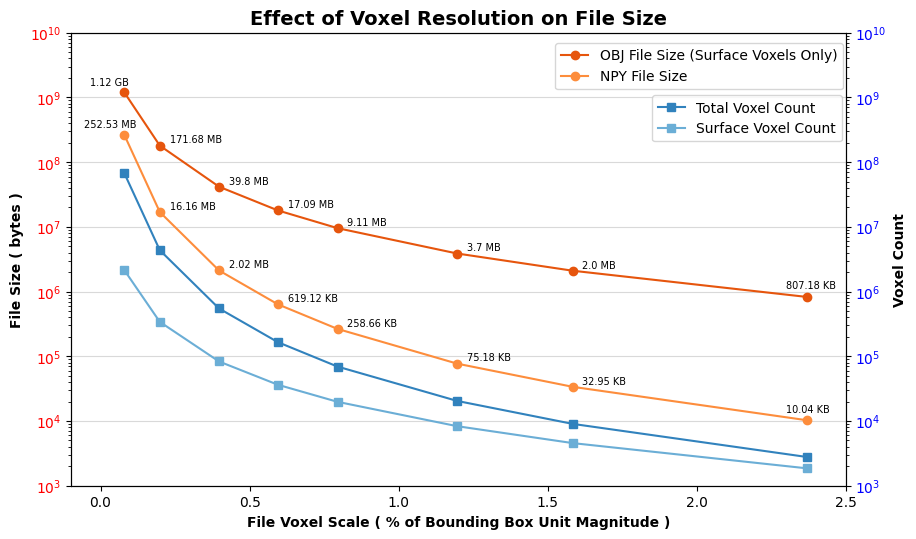

In [15]:
# Dual Y axis plot of file size, voxel count vs voxel scale resolution

fig, ax1 = plt.subplots( figsize=(10,6), dpi=100 )
ax2 = ax1.twinx()

y_lower, y_upper = 10**3, 10**10
ax1.set_ylim( y_lower, y_upper )
ax2.set_ylim( y_lower, y_upper )

x_lower, x_upper = -0.1, 2.5
ax1.set_xlim( x_lower, x_upper)

ax1.plot( voxel_df['Voxel Scale Percentage'], voxel_df['OBJ Raw Size'], color="#e6550d", marker="o", label='OBJ File Size (Surface Voxels Only)')
ax1.plot( voxel_df['Voxel Scale Percentage'], voxel_df['NPY Raw Size'], color="#fd8d3c", marker="o", label='NPY File Size')
ax1.set_yscale('log')
ax1.set_xlabel("File Voxel Scale ( % of Bounding Box Unit Magnitude )", fontweight='semibold', fontsize=10)
ax1.set_ylabel("File Size ( bytes )", fontweight='semibold', fontsize=10)
ax1.tick_params(axis ='y', labelcolor = 'red') 

ax2.plot( voxel_df['Voxel Scale Percentage'], voxel_df['Voxel Count'], color="#3182bd", marker="s", label='Total Voxel Count')
ax2.plot( voxel_df['Voxel Scale Percentage'], voxel_df['Surface Voxel Count'], color="#6baed6", marker="s", label='Surface Voxel Count')
ax2.set_yscale('log')
ax2.set_ylabel("Voxel Count", fontweight='semibold', fontsize=10)
ax2.tick_params(axis ='y', labelcolor = 'blue')

# Plot Email Filesize Limit
# ax1.axhline( y=25000000, color='0.75', linestyle='--')
# ax1.axvline( x=0.52, color='0.75', linestyle='--')

# OBJ File Size Labels
for index, data in voxel_df.iterrows():
	if index == 0:
		ax1.annotate(data['OBJ File Surf-Vox Size'], (data['Voxel Scale Percentage'],data['OBJ Raw Size']),
				xytext=(-25,5), textcoords='offset points',
				family='sans-serif', fontsize=7, color='black')
	elif index == len(voxel_df)-1:
		ax1.annotate(data['OBJ File Surf-Vox Size'], (data['Voxel Scale Percentage'],data['OBJ Raw Size']),
				xytext=(-15,6), textcoords='offset points',
				family='sans-serif', fontsize=7, color='black')
	else:
		ax1.annotate(data['OBJ File Surf-Vox Size'], (data['Voxel Scale Percentage'],data['OBJ Raw Size']),
				xytext=(7,2), textcoords='offset points',
				family='sans-serif', fontsize=7, color='black')

# NPY File Size Labels (Excludes First and Last)
for index, data in voxel_df.iterrows():
	if index == 0:
		ax1.annotate(data['NPY File Size'], (data['Voxel Scale Percentage'],data['NPY Raw Size']),
				xytext=(-29,5), textcoords='offset points',
				family='sans-serif', fontsize=7, color='black')
	elif index == len(voxel_df)-1:
		ax1.annotate(data['NPY File Size'], (data['Voxel Scale Percentage'],data['NPY Raw Size']),
				xytext=(-15,6), textcoords='offset points',
				family='sans-serif', fontsize=7, color='black')
	else:
		ax1.annotate(data['NPY File Size'], (data['Voxel Scale Percentage'],data['NPY Raw Size']),
				xytext=(7,2), textcoords='offset points',
				family='sans-serif', fontsize=7, color='black')

ax1.set_title('Effect of Voxel Resolution on File Size', fontsize=14, fontweight='bold')
ax1.grid(axis='y', color='0.85')
ax1.legend(loc = (0.625, 0.875))
ax2.legend(loc = (0.75, 0.76))

plt.show()

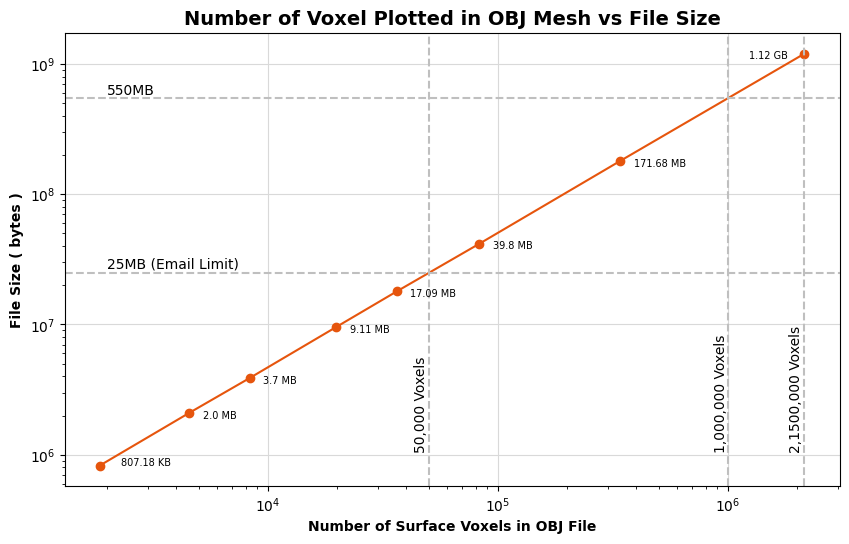

In [16]:
# Plot Surface Voxel Count vs OBJ Mesh File Size

fig, ax = plt.subplots( figsize=(10,6), dpi=100 )

ax.plot( voxel_df['Surface Voxel Count'], voxel_df['OBJ Raw Size'], color="#e6550d", marker="o", label='OBJ File Size (Surface Voxels Only)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("Number of Surface Voxels in OBJ File", fontweight='semibold', fontsize=10)
ax.set_ylabel("File Size ( bytes )", fontweight='semibold', fontsize=10) 

# Plot key file size to voxel count values 
ax.axhline( y=25000000, color='0.75', linestyle='--')
ax.text( 2000, 27000000, '25MB (Email Limit)' )
ax.axhline( y=550000000, color='0.75', linestyle='--')
ax.text( 2000, 580000000, '550MB' )
ax.axvline( x=50000, color='0.75', linestyle='--')
ax.text( 43000, 1100000, '50,000 Voxels', rotation=90 )
ax.axvline( x=1000000, color='0.75', linestyle='--')
ax.text( 870000, 1100000, '1,000,000 Voxels', rotation=90 )
ax.axvline( x=2152000, color='0.75', linestyle='--')
ax.text( 1850000, 1100000, '2,1500,000 Voxels', rotation=90 )

# OBJ File Size Labels
for index, data in voxel_df.iterrows():
	if index == 0:
		ax.annotate(data['OBJ File Surf-Vox Size'], (data['Surface Voxel Count'],data['OBJ Raw Size']),
				xytext=(-40,-4), textcoords='offset points',
				family='sans-serif', fontsize=7, color='black')
	elif index == len(voxel_df)-1:
		ax.annotate(data['OBJ File Surf-Vox Size'], (data['Surface Voxel Count'],data['OBJ Raw Size']),
				xytext=(15,0), textcoords='offset points',
				family='sans-serif', fontsize=7, color='black')
	else:
		ax.annotate(data['OBJ File Surf-Vox Size'], (data['Surface Voxel Count'],data['OBJ Raw Size']),
				xytext=(10,-4), textcoords='offset points',
				family='sans-serif', fontsize=7, color='black')

ax.set_title('Number of Voxel Plotted in OBJ Mesh vs File Size', fontsize=14, fontweight='bold')
ax.grid(axis='y', color='0.85')
ax.grid(axis='x', color='0.85')

plt.show()

---
#### Influence of Model Geometry on Surface Voxel Count
Removing all internal voxels leaves an identical external view of the voxel model. Only exporting voxels that define the surface of the model benefits the file size of the created OBJ mesh. The total savings is not consistent across models and is dependent on the external surface geometry. The example below demonstrates how three models with similar total voxel counts produce surface views with very different surface voxel counts. 

In [17]:
# Load models with similar total voxel counts
fcc_shell = np.load("./example_visualized_voxels/surface_geometry_voxel_count_comparison/fcc_shell.npy")
fcc_center = np.load("./example_visualized_voxels/surface_geometry_voxel_count_comparison/fcc_center.npy")
lobe_gear = np.load("./example_visualized_voxels/surface_geometry_voxel_count_comparison/lobe_gear.npy")

comparison_models = [ 
    {'name': 'Unit Shell FCC', 'model': fcc_shell}, 
    {'name': 'Centered FCC', 'model': fcc_center}, 
    {'name': 'Lobe Gear', 'model': lobe_gear} ]

In [18]:
# Collect voxel totals, shapes, and file size

df_data = []
output_path = "./example_visualized_voxels/surface_geometry_voxel_count_comparison/obj_models/"

for voxel_model in comparison_models:
    filenames = { 
        'full': Template('$name full.obj').substitute( name=voxel_model['name'].lower() ).replace(" ", "_"),
        'surf': Template('$name surface.obj').substitute( name=voxel_model['name'].lower() ).replace(" ", "_")}

    full_voxel_model = voxel_model['model']
    surface_view_voxel_model = get_surface_voxels(full_voxel_model)

    total_count = np.count_nonzero( full_voxel_model )
    surface_count = np.count_nonzero( surface_view_voxel_model )

    voxel_array2voxel_mesh_obj( os.path.join( output_path, filenames['full'] ), full_voxel_model, surface_view=False )
    voxel_array2voxel_mesh_obj( os.path.join( output_path, filenames['surf'] ), surface_view_voxel_model, surface_view=False )

    full_obj_filesize = os.path.getsize( os.path.join( output_path, filenames['full'] ) )
    surface_obj_filesize = os.path.getsize( os.path.join( output_path, filenames['surf'] ) )

    df_data.append([ 
        total_count,
        surface_count,
        round(( surface_count/total_count )*100, 2),
        full_voxel_model.shape,
        full_obj_filesize,
        surface_obj_filesize,
        round(( surface_obj_filesize/full_obj_filesize )*100, 2)
    ])

# df_data

In [19]:
# Build Dataframe

filenames = [
    'Bounded FCC\n Lattice Unit Cell',
    'Centered FCC\n Lattice Unit Cell',
    'Lobe Gear Model']

geom_v_count_columns = [ 
    'Full Voxel Count', 
    'Surface Voxel Count', 
    'Surface Voxel Count %', 
    'Voxel Grid Shape', 
    'Full Voxel Model OBJ Filesize',
    'Surface Voxel Model OBJ Filesize',
    'Surface Voxel OBJ Filesize %',]

geom_v_surf_count_df = pd.DataFrame(df_data, columns=geom_v_count_columns, index=filenames)

geom_v_surf_count_df

,Full Voxel Count,Surface Voxel Count,Surface Voxel Count %,Voxel Grid Shape,Full Voxel Model OBJ Filesize,Surface Voxel Model OBJ Filesize,Surface Voxel OBJ Filesize %
Bounded FCC\n Lattice Unit Cell,63356,32704,51.62,"(64, 64, 64)",31684906,16113690,50.86
Centered FCC\n Lattice Unit Cell,63356,24095,38.03,"(64, 64, 64)",31684906,11740318,37.05
Lobe Gear Model,63404,19149,30.20,"(80, 80, 34)",31709290,9227750,29.10


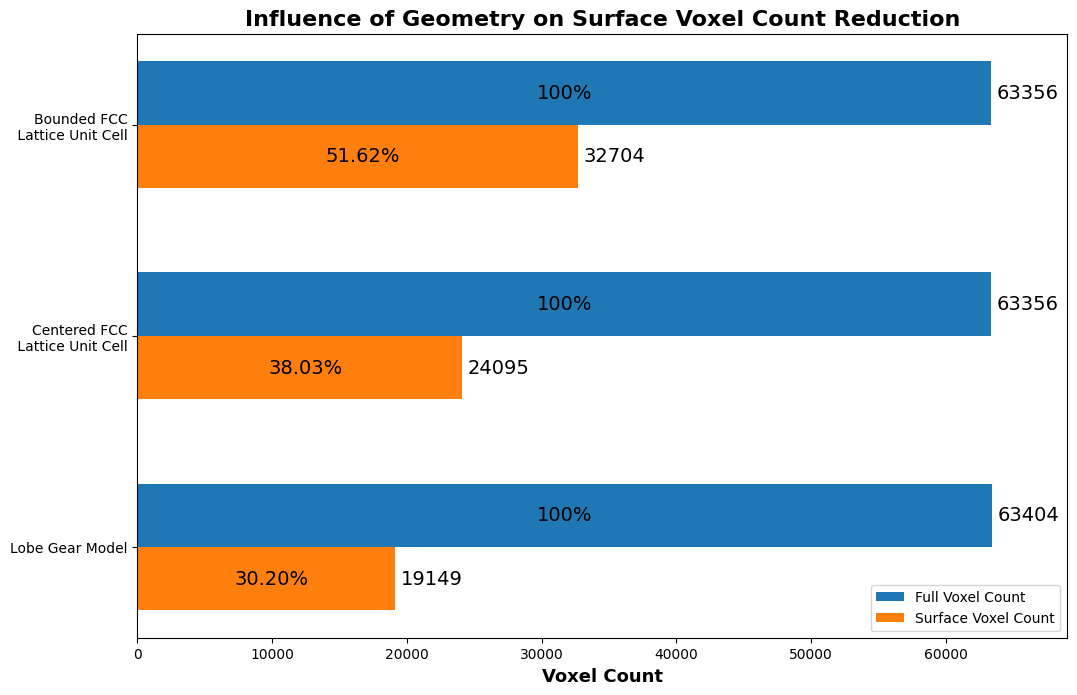

In [20]:
# Plot the reduced surface voxel count for each model

fig, ax = plt.subplots(figsize=(12,8), dpi=100)

ylabel_loc = np.arange(len(geom_v_surf_count_df.index))
bar_span = 0.3

full_count = ax.barh(ylabel_loc-bar_span/2, geom_v_surf_count_df['Full Voxel Count'], bar_span, label='Full Voxel Count')
surf_count = ax.barh(ylabel_loc+bar_span/2, geom_v_surf_count_df['Surface Voxel Count'], bar_span, label='Surface Voxel Count')

ax.set_title('Influence of Geometry on Surface Voxel Count Reduction', fontdict={'size':16, 'weight':'bold'})
ax.set_xlabel('Voxel Count', fontsize=13, fontweight='semibold')
ax.set_yticks( ylabel_loc, labels=geom_v_surf_count_df.index, fontsize=10, fontweight='medium')
ax.invert_yaxis()
ax.legend()

ax.bar_label(full_count, fontsize=14, padding=4)
ax.bar_label(surf_count, fontsize=14, padding=4)
ax.bar_label(full_count, labels=['100%' for p in np.arange(len(geom_v_surf_count_df.index))], label_type='center', fontsize=14)
ax.bar_label(surf_count, labels=['%.2f%%' % p for p in geom_v_surf_count_df['Surface Voxel Count %']], label_type='center', fontsize=14, padding=4)
ax.set_xlim(right=69000)

plt.show()

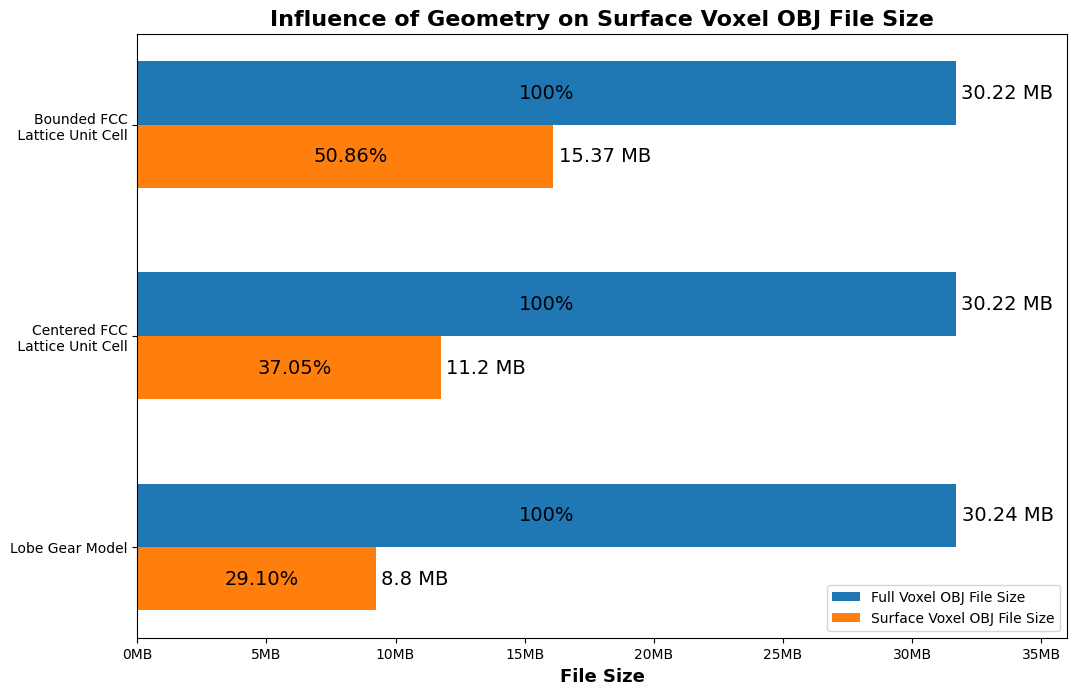

In [21]:
# Plot the reduced surface voxel OBJ file size for each model

fig, ax = plt.subplots(figsize=(12,8), dpi=100)

label_fmt = lambda x, pos: '{:.0f}MB'.format(x/1000000, pos)

ylabel_loc = np.arange( len(geom_v_surf_count_df.index) )
bar_span = 0.3

full_count = ax.barh( ylabel_loc-bar_span/2, geom_v_surf_count_df['Full Voxel Model OBJ Filesize'], bar_span, label='Full Voxel OBJ File Size' )
surf_count = ax.barh( ylabel_loc+bar_span/2, geom_v_surf_count_df['Surface Voxel Model OBJ Filesize'], bar_span, label='Surface Voxel OBJ File Size' )

ax.set_title('Influence of Geometry on Surface Voxel OBJ File Size', fontdict={'size':16, 'weight':'bold'})
ax.set_xlabel('File Size', fontsize=13, fontweight='semibold')
ax.set_yticks( ylabel_loc, labels=geom_v_surf_count_df.index, fontsize=10, fontweight='medium')
ax.invert_yaxis()
ax.legend()

ax.bar_label(full_count, labels=[ convert_size(s) for s in geom_v_surf_count_df['Full Voxel Model OBJ Filesize']], fontsize=14, padding=4 )
ax.bar_label(surf_count, labels=[ convert_size(s) for s in geom_v_surf_count_df['Surface Voxel Model OBJ Filesize']], fontsize=14, padding=4 )
ax.bar_label(full_count, labels=['100%' for p in np.arange(len(geom_v_surf_count_df.index))], label_type='center', fontsize=14 )
ax.bar_label(surf_count, labels=['%.2f%%' % p for p in geom_v_surf_count_df['Surface Voxel OBJ Filesize %']], label_type='center', fontsize=14, padding=4 )
ax.set_xlim(right=36000000)

ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(label_fmt))

plt.show()